In [7]:
# importing all the important modules 
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os 
import torchvision.transforms as transforms

In [9]:
import os
import pandas as pd

base_path = "/kaggle/input/animal-faces/afhq"

image_paths = []
labels = []

# Loop through split folders: train, val
for split in os.listdir(base_path):
    split_path = os.path.join(base_path, split)

    if not os.path.isdir(split_path):
        continue

    # Loop through class folders: cat, dog, wild
    for class_name in os.listdir(split_path):
        class_path = os.path.join(split_path, class_name)

        if not os.path.isdir(class_path):
            continue

        # Loop through images inside each class folder
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            
            image_paths.append(img_path)
            labels.append(class_name)   # <-- Correct label

df = pd.DataFrame({"image_path": image_paths, "labels": labels})
df.head()


,image_path,labels
0,/kaggle/input/animal-faces/afhq/val/dog/flickr...,dog
1,/kaggle/input/animal-faces/afhq/val/dog/pixaba...,dog
2,/kaggle/input/animal-faces/afhq/val/dog/flickr...,dog
3,/kaggle/input/animal-faces/afhq/val/dog/flickr...,dog
4,/kaggle/input/animal-faces/afhq/val/dog/pixaba...,dog


<Axes: xlabel='labels'>

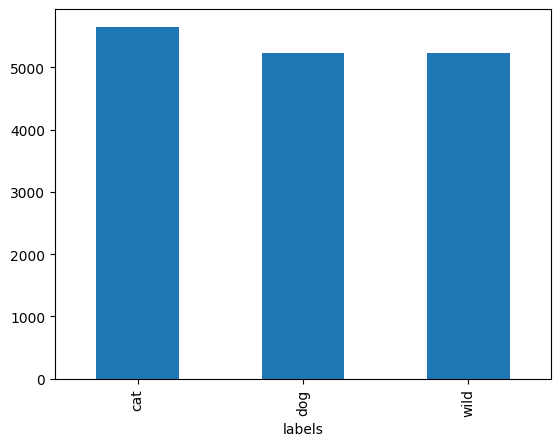

In [10]:
df['labels'].value_counts().plot(kind='bar')

In [11]:
# splitting the data into training, val, test datasets 
X_train, X_val, y_train, y_val = train_test_split(
    df['image_path'], df['labels'],
    test_size=0.3, shuffle=True, stratify=df['labels']
)

X_val, X_test, y_val, y_test = train_test_split(
    X_val, y_val,
    test_size=0.5, shuffle=True, stratify=y_val
)

# Option 1: reset index
X_train = X_train.reset_index(drop=True)
X_val   = X_val.reset_index(drop=True)
X_test  = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_val   = y_val.reset_index(drop=True)
y_test  = y_test.reset_index(drop=True)

In [12]:
# Converting the data from Cat, Dog, Wild and doing some transformation 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

label_encoder = LabelEncoder()
label_encoder.fit(df['labels'])

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

cuda


In [13]:
# keep this simple in dataset
class CustomImageDataset(Dataset):
    def __init__(self, x, y, transformer=None):
        self.x = x
        self.y = torch.tensor(label_encoder.transform(y), dtype=torch.long)
        self.transformer = transformer

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        image = Image.open(self.x[index]).convert("RGB")
        if self.transformer is not None:
            image = self.transformer(image)   # CPU tensor
        label = self.y[index]                # CPU tensor
        return image, label


In [14]:
# Creating the dataset for train, val, test
train_dataset = CustomImageDataset(X_train, y_train, transformer=transform)
val_dataset   = CustomImageDataset(X_val,   y_val,   transformer=transform)
test_dataset  = CustomImageDataset(X_test,  y_test,  transformer=transform)


In [15]:
# new lets determine the learning prams
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 10

In [16]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,num_workers=4, pin_memory=True)
val_loader = val_loader = DataLoader(val_dataset, batch_size=32,num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [17]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pooling = nn.MaxPool2d(2,2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear((128*16*16), 128)
        self.output = nn.Linear(128, 3)
    def forward(self, x):#--> (128, 128, 3)
        x = self.conv1(x) #--> (128, 128, 32)
        x = self.pooling(x)# -->(64, 64, 32)
        x = self.relu(x)# -->(64, 64, 32)
        x = self.conv2(x)# -->(64, 64, 64)
        x = self.pooling(x)# -->(32, 32, 64)
        x = self.relu(x)# -->(32, 32, 64)
        x = self.conv3(x)# -->(32, 32, 128)
        x = self.pooling(x)# -->(16, 16, 128) (128, 16, 16)
        x = self.relu(x)#
        x = self.flatten(x)
        x = self.linear(x)
        x = self.output(x)
        return x



In [18]:
model = Net().to(device)

In [19]:
from torchsummary import summary 
summary(model, input_size=(3, 128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

In [20]:
loss_fun = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

In [21]:
# ---- GPU setup (add this once before training) ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
# ---------------------------------------------------

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for epoch in range(1, EPOCHS +1):
    model.train()
    train_running_loss = 0.0
    train_correct = 0
    train_total = 0
    for images, labels in train_loader:
        # move batch to GPU
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        pred_img = model(images)
        loss = loss_fun(pred_img , labels)
        loss.backward()
        optimizer.step()
        train_running_loss += loss.item() * images.size(0)
        preds = pred_img.argmax(dim=1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)
    train_loss = train_running_loss / train_total
    train_acc = train_correct / train_total

    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            # move batch to GPU
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = loss_fun(outputs, labels)
            val_running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_running_loss / val_total if val_total > 0 else 0.0
    val_acc = val_correct / val_total if val_total > 0 else 0.0

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch}/{EPOCHS} | "
          f"Train loss: {train_loss:.4f}, Train acc: {train_acc*100:.2f}% | "
          f"Val loss: {val_loss:.4f}, Val acc: {val_acc*100:.2f}%")

Epoch 1/10 | Train loss: 0.5405, Train acc: 77.23% | Val loss: 0.3084, Val acc: 88.38%
Epoch 2/10 | Train loss: 0.2567, Train acc: 90.44% | Val loss: 0.2194, Val acc: 91.90%
Epoch 3/10 | Train loss: 0.1788, Train acc: 93.49% | Val loss: 0.1858, Val acc: 93.51%
Epoch 4/10 | Train loss: 0.1288, Train acc: 95.35% | Val loss: 0.1342, Val acc: 95.70%
Epoch 5/10 | Train loss: 0.0984, Train acc: 96.59% | Val loss: 0.1358, Val acc: 95.12%
Epoch 6/10 | Train loss: 0.0732, Train acc: 97.40% | Val loss: 0.1169, Val acc: 95.62%
Epoch 7/10 | Train loss: 0.0596, Train acc: 97.92% | Val loss: 0.1294, Val acc: 95.49%
Epoch 8/10 | Train loss: 0.0491, Train acc: 98.28% | Val loss: 0.1248, Val acc: 96.03%
Epoch 9/10 | Train loss: 0.0385, Train acc: 98.71% | Val loss: 0.1737, Val acc: 94.79%
Epoch 10/10 | Train loss: 0.0278, Train acc: 99.20% | Val loss: 0.1149, Val acc: 96.40%


In [37]:
with torch.no_grad():
    total_acc_test = 0
    total_samples = 0
    for images, labels in test_loader:
        # move batch to GPU
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        acc = (preds == labels).sum().item()
        total_acc_test += acc
        total_samples += labels.size(0)
    accuracy = total_acc_test / total_samples
    print("Test Accuracy:", accuracy)

Test Accuracy: 0.9590909090909091


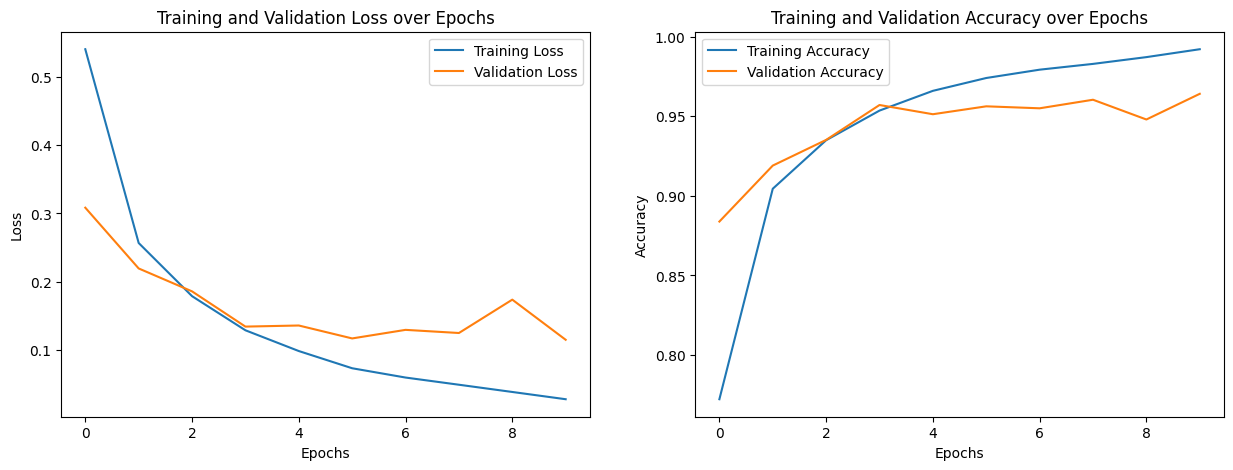

In [50]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(history["train_loss"], label='Training Loss')
axs[0].plot(history["val_loss"], label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend()

axs[1].plot(history["train_acc"], label='Training Accuracy')
axs[1].plot(history["val_acc"], label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].legend()


* i can see this abit of overfitting 